## Seeing the World: Model Training

### Specify train and validate input folders

In [1]:
#train input folder
train_input_folder = '/data/data4/farmer_market'

#validation input folder
validate_input_folder = '/data/data4/validate/farmer_market'

In [2]:
from imutils import paths
import os
import shutil
import random

def split_data(directory, validate_directory='validation', split=0.8): 
  directories = [os.path.join(directory, o) for o in os.listdir(directory) 
                    if os.path.isdir(os.path.join(directory,o))]
  for directory in directories:
    image_paths = list(paths.list_images(directory))
    
    random.seed(32)
    random.shuffle(image_paths)
    image_paths
   
    # compute the training and testing split
    i = int(len(image_paths) * split)    
    train_paths = image_paths[:i]
    selected_for_validation_paths = image_paths[i:]
    for path in selected_for_validation_paths:
       category = os.path.basename(os.path.normpath(directory)) 
       dest_path = os.path.join(validate_directory, category)
       if not os.path.exists(dest_path):
           os.makedirs(dest_path)
           os.chmod(dest_path, 0o777)
       try: 
           shutil.move(path, dest_path)
       except OSError as e:
           if e.errno == errno.EEXIST:
               print('Image already exists.')
           else:
               raise     

  

In [3]:
split_data(directory='/data/data4/farmer_market',
           validate_directory= '/data/data4/validate/farmer_market') 

### Create train and validate data generators

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#apply image augmentation
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2)

validate_image_generator = ImageDataGenerator(rescale=1./255)



In [5]:
batch_size = 30
image_width = 224
image_height = 224
IMAGE_WIDTH_HEIGHT = (image_width, image_height)

class_mode = 'categorical'

#create train data generator flowing from train_input_folder
train_generator = train_image_generator.flow_from_directory(
            train_input_folder,
            target_size=IMAGE_WIDTH_HEIGHT,
            batch_size=batch_size,
            class_mode=class_mode)

#create validation data generator flowing from validate_input_folder
validation_generator = validate_image_generator.flow_from_directory(
        validate_input_folder,
        target_size=IMAGE_WIDTH_HEIGHT,
        batch_size=batch_size,
        class_mode=class_mode)

Found 1539 images belonging to 64 classes.
Found 414 images belonging to 64 classes.


### Create Custom Model

In [6]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

total_classes = 60
activation_function = 'softmax'
loss = 'categorical_crossentropy'

img_input = layers.Input(shape=(image_width, image_height, 3))

x = layers.Conv2D(32, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Flatten()(x)

x = layers.Dense(512, activation='relu')(x)

x = layers.Dropout(0.5)(x)

output = layers.Dense(total_classes, activation=activation_function)(x)

model = Model(img_input, output)
model.compile(loss=loss,
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

### Train Custom Model

In [8]:
import os, datetime
import tensorflow as tf

epochs = 5
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

logdir = os.path.join("tf_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit_generator(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      validation_data=validation_generator,
      validation_steps=validation_steps,
      callbacks=[tensorboard_callback],
      epochs=epochs)

Epoch 1/5
23/23 [==============================] - 140s 6s/step - loss: 3.0907 - accuracy: 0.2127 - val_loss: 2.9866 - val_accuracy: 0.2726
Epoch 2/5
23/23 [==============================] - 137s 6s/step - loss: 2.7565 - accuracy: 0.2703 - val_loss: 2.7382 - val_accuracy: 0.2462
Epoch 3/5
23/23 [==============================] - 137s 6s/step - loss: 2.5411 - accuracy: 0.2866 - val_loss: 2.5862 - val_accuracy: 0.3453
Epoch 4/5
23/23 [==============================] - 133s 6s/step - loss: 2.1530 - accuracy: 0.3604 - val_loss: 2.2663 - val_accuracy: 0.4547
Epoch 5/5
23/23 [==============================] - 134s 6s/step - loss: 2.0415 - accuracy: 0.3855 - val_loss: 2.1194 - val_accuracy: 0.5026


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

### Using Transfer Learning

In [6]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19

image_width=224
image_height=224
IMAGE_SHAPE = (image_width, image_height, 3)

base_model = tf.keras.applications.VGG19(input_shape=IMAGE_SHAPE, include_top=False,weights='imagenet')

base_model.summary()


Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
keras = tf.keras
IMAGE_WIDTH_HEIGHT = (image_width, image_height)
batch_size=30
class_mode="categorical"

total_classes = 64
activation_function = 'softmax'
loss = 'categorical_crossentropy'


train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=keras.applications.vgg19.preprocess_input,
            rescale=1.0/255.0,
            shear_range=0.2, 
            zoom_range=[0.9, 1.25],
            brightness_range=[0.5, 1.5],
            horizontal_flip=True,
            vertical_flip=True)

     
validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=keras.applications.vgg19.preprocess_input,
            rescale=1.0/255.0)


train_generator = train_image_generator.flow_from_directory(
            train_input_folder,
            target_size=IMAGE_WIDTH_HEIGHT,
            batch_size=batch_size,
            class_mode=class_mode)

validation_generator = validation_image_generator.flow_from_directory(
            validate_input_folder,
            target_size=IMAGE_WIDTH_HEIGHT,
            batch_size=batch_size,
            class_mode=class_mode)

Found 1539 images belonging to 64 classes.
Found 414 images belonging to 64 classes.


In [8]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import os

reload_checkpoint=True

total_classes=64
img_input = layers.Input(shape=(image_width, image_height, 3))

global_average_layer = layers.GlobalAveragePooling2D()
prediction_layer = layers.Dense(total_classes, activation='softmax')


model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

checkpoint_path = "/data/train_model_fruit_veggie_9/chkpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


if (reload_checkpoint and os.path.isdir(checkpoint_path)):
   try:
      model.load_weights(checkpoint_path)
      print('loaded weights from checkpoint')  
   except Exception:
      print('no checkpointed weights')
      pass

if not os.path.isdir(checkpoint_path):
   os.makedirs(checkpoint_path)


print("Number of layers in the base model: ", len(base_model.layers))

base_model.trainable = False

model.compile(loss=loss,
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

model.summary()






no checkpointed weights
Number of layers in the base model:  22
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
Total params: 20,057,216
Trainable params: 32,832
Non-trainable params: 20,024,384
_________________________________________________________________


In [9]:
import datetime, os

epochs = 20
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size
#steps_per_epoch = 50
#validation_steps = 50

logdir = os.path.join("/data/tf_logs_9", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                         save_weights_only=True, save_best_only=True,
                                                         verbose=1)

history = model.fit_generator(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      validation_data=validation_generator,
      validation_steps=validation_steps,
      callbacks=[checkpoint_callback, tensorboard_callback],
      epochs=epochs)



Epoch 1/20
50/51 [============================>.] - ETA: 2s - loss: 3.6522 - accuracy: 0.1116
Epoch 00001: val_loss improved from inf to 3.32191, saving model to /data/train_model_fruit_veggie_9/chkpt
51/51 [==============================] - 158s 3s/step - loss: 3.6442 - accuracy: 0.1160 - val_loss: 3.3219 - val_accuracy: 0.2256
Epoch 2/20
50/51 [============================>.] - ETA: 2s - loss: 3.1175 - accuracy: 0.3063
Epoch 00002: val_loss improved from 3.32191 to 2.93810, saving model to /data/train_model_fruit_veggie_9/chkpt
51/51 [==============================] - 156s 3s/step - loss: 3.1184 - accuracy: 0.3088 - val_loss: 2.9381 - val_accuracy: 0.4564
Epoch 3/20
50/51 [============================>.] - ETA: 2s - loss: 2.8081 - accuracy: 0.4402
Epoch 00003: val_loss improved from 2.93810 to 2.62928, saving model to /data/train_model_fruit_veggie_9/chkpt
51/51 [==============================] - 154s 3s/step - loss: 2.8028 - accuracy: 0.4427 - val_loss: 2.6293 - val_accuracy: 0.5103

Text(0.5, 0, 'epoch')

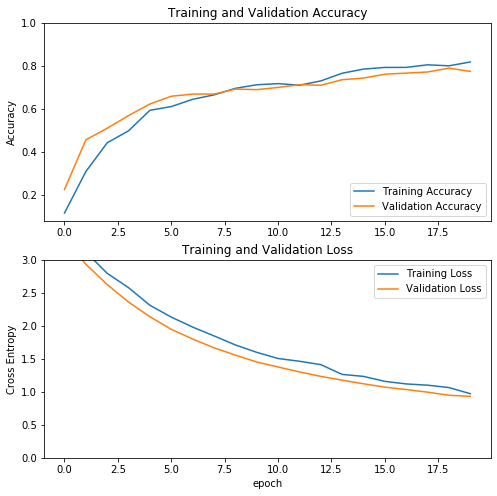

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 3])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

### Continue Training

In [11]:
import datetime, os

epochs = 20
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size
#steps_per_epoch = 50
#validation_steps = 50

logdir = os.path.join("/data/tf_logs_9", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                         save_weights_only=True, save_best_only=True,
                                                         verbose=1)

history = model.fit_generator(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      validation_data=validation_generator,
      validation_steps=validation_steps,
      callbacks=[checkpoint_callback, tensorboard_callback],
      epochs=epochs)



Epoch 1/20
50/51 [============================>.] - ETA: 2s - loss: 0.9806 - accuracy: 0.8229
Epoch 00001: val_loss improved from inf to 0.88820, saving model to /data/train_model_fruit_veggie_9/chkpt
51/51 [==============================] - 158s 3s/step - loss: 0.9780 - accuracy: 0.8237 - val_loss: 0.8882 - val_accuracy: 0.8026
Epoch 2/20
50/51 [============================>.] - ETA: 2s - loss: 0.9473 - accuracy: 0.8303
Epoch 00002: val_loss improved from 0.88820 to 0.86395, saving model to /data/train_model_fruit_veggie_9/chkpt
51/51 [==============================] - 158s 3s/step - loss: 0.9518 - accuracy: 0.8284 - val_loss: 0.8640 - val_accuracy: 0.8026
Epoch 3/20
50/51 [============================>.] - ETA: 2s - loss: 0.8999 - accuracy: 0.8404
Epoch 00003: val_loss improved from 0.86395 to 0.84120, saving model to /data/train_model_fruit_veggie_9/chkpt
51/51 [==============================] - 155s 3s/step - loss: 0.9054 - accuracy: 0.8383 - val_loss: 0.8412 - val_accuracy: 0.8026

Text(0.5, 0, 'epoch')

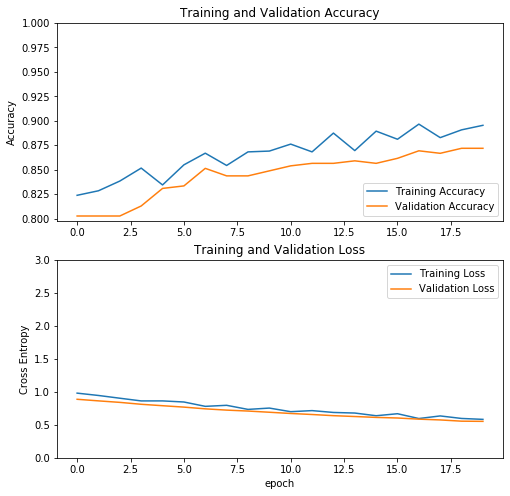

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 3])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

### Continue Training

In [13]:
import datetime, os

epochs = 20
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size
#steps_per_epoch = 50
#validation_steps = 50

logdir = os.path.join("/data/tf_logs_9", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                         save_weights_only=True, save_best_only=True,
                                                         verbose=1)

history = model.fit_generator(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      validation_data=validation_generator,
      validation_steps=validation_steps,
      callbacks=[checkpoint_callback, tensorboard_callback],
      epochs=epochs)



Epoch 1/20
50/51 [============================>.] - ETA: 2s - loss: 0.5618 - accuracy: 0.8993
Epoch 00001: val_loss improved from inf to 0.53764, saving model to /data/train_model_fruit_veggie_9/chkpt
51/51 [==============================] - 157s 3s/step - loss: 0.5629 - accuracy: 0.8993 - val_loss: 0.5376 - val_accuracy: 0.8769
Epoch 2/20
50/51 [============================>.] - ETA: 2s - loss: 0.5700 - accuracy: 0.9040
Epoch 00002: val_loss improved from 0.53764 to 0.52669, saving model to /data/train_model_fruit_veggie_9/chkpt
51/51 [==============================] - 155s 3s/step - loss: 0.5674 - accuracy: 0.9039 - val_loss: 0.5267 - val_accuracy: 0.8744
Epoch 3/20
50/51 [============================>.] - ETA: 2s - loss: 0.5428 - accuracy: 0.9040
Epoch 00003: val_loss improved from 0.52669 to 0.51983, saving model to /data/train_model_fruit_veggie_9/chkpt
51/51 [==============================] - 157s 3s/step - loss: 0.5413 - accuracy: 0.9052 - val_loss: 0.5198 - val_accuracy: 0.8795

Text(0.5, 0, 'epoch')

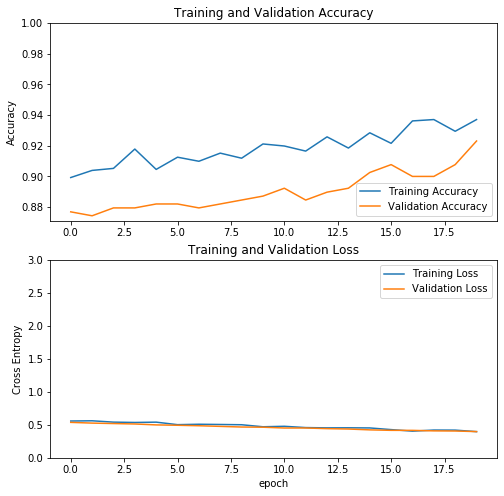

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 3])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

### Continue Training

In [15]:
import datetime, os

epochs = 20
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size
#steps_per_epoch = 50
#validation_steps = 50

logdir = os.path.join("/data/tf_logs_9", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                         save_weights_only=True, save_best_only=True,
                                                         verbose=1)

history = model.fit_generator(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      validation_data=validation_generator,
      validation_steps=validation_steps,
      callbacks=[checkpoint_callback, tensorboard_callback],
      epochs=epochs)



Epoch 1/20
50/51 [============================>.] - ETA: 2s - loss: 0.4014 - accuracy: 0.9391
Epoch 00001: val_loss improved from inf to 0.39068, saving model to /data/train_model_fruit_veggie_9/chkpt
51/51 [==============================] - 157s 3s/step - loss: 0.4034 - accuracy: 0.9390 - val_loss: 0.3907 - val_accuracy: 0.9154
Epoch 2/20
50/51 [============================>.] - ETA: 2s - loss: 0.3765 - accuracy: 0.9412
Epoch 00002: val_loss improved from 0.39068 to 0.38798, saving model to /data/train_model_fruit_veggie_9/chkpt
51/51 [==============================] - 156s 3s/step - loss: 0.3769 - accuracy: 0.9404 - val_loss: 0.3880 - val_accuracy: 0.9154
Epoch 3/20
50/51 [============================>.] - ETA: 2s - loss: 0.3780 - accuracy: 0.9439
Epoch 00003: val_loss improved from 0.38798 to 0.38089, saving model to /data/train_model_fruit_veggie_9/chkpt
51/51 [==============================] - 153s 3s/step - loss: 0.3766 - accuracy: 0.9443 - val_loss: 0.3809 - val_accuracy: 0.9179

Text(0.5, 0, 'epoch')

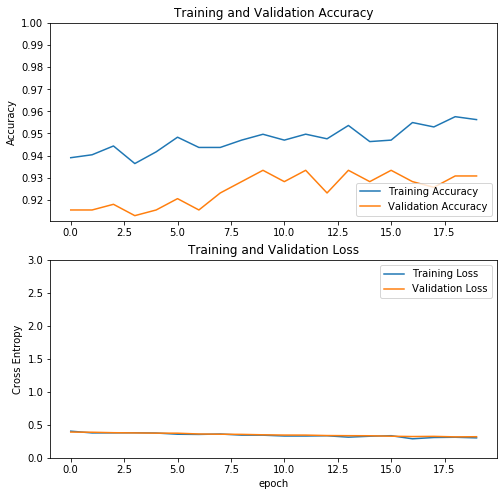

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 3])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

### Continue Training

In [17]:
import datetime, os

epochs = 20
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size
#steps_per_epoch = 50
#validation_steps = 50

logdir = os.path.join("/data/tf_logs_9", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                         save_weights_only=True, save_best_only=True,
                                                         verbose=1)

history = model.fit_generator(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      validation_data=validation_generator,
      validation_steps=validation_steps,
      callbacks=[checkpoint_callback, tensorboard_callback],
      epochs=epochs)



Epoch 1/20
50/51 [============================>.] - ETA: 2s - loss: 0.2906 - accuracy: 0.9587
Epoch 00001: val_loss improved from inf to 0.31028, saving model to /data/train_model_fruit_veggie_9/chkpt
51/51 [==============================] - 158s 3s/step - loss: 0.2918 - accuracy: 0.9589 - val_loss: 0.3103 - val_accuracy: 0.9333
Epoch 2/20
50/51 [============================>.] - ETA: 2s - loss: 0.2899 - accuracy: 0.9540
Epoch 00002: val_loss improved from 0.31028 to 0.30393, saving model to /data/train_model_fruit_veggie_9/chkpt
51/51 [==============================] - 156s 3s/step - loss: 0.2892 - accuracy: 0.9543 - val_loss: 0.3039 - val_accuracy: 0.9410
Epoch 3/20
50/51 [============================>.] - ETA: 2s - loss: 0.2933 - accuracy: 0.9567
Epoch 00003: val_loss did not improve from 0.30393
51/51 [==============================] - 155s 3s/step - loss: 0.2966 - accuracy: 0.9556 - val_loss: 0.3046 - val_accuracy: 0.9282
Epoch 4/20
50/51 [============================>.] - ETA: 2s

Text(0.5, 0, 'epoch')

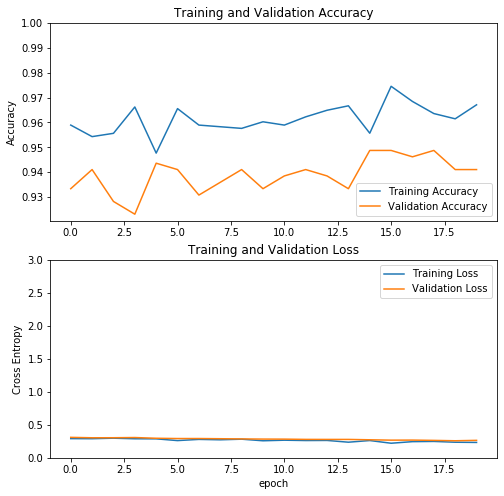

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 3])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

### Fine Tuning

In [19]:
import datetime, os

loss = 'categorical_crossentropy'

checkpoint_path = "/data/train_model_fruit_veggie_9/chkpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


if (reload_checkpoint and os.path.isdir(checkpoint_path)):
   try:
      model.load_weights(checkpoint_path)
   except Exception:
      pass

if not os.path.isdir(checkpoint_path):
   os.makedirs(checkpoint_path)

base_model.trainable = True

# Fine tune start from layer 10
fine_tune_at = 10

# Freeze all layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
     layer.trainable = False

model.compile(loss=loss,
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)                30780     
Total params: 20,055,164
Trainable params: 18,319,676
Non-trainable params: 1,735,488
_________________________________________________________________


In [20]:
import datetime, os

epochs = 10
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size
#steps_per_epoch = 50
#validation_steps = 50

logdir = os.path.join("/data/tf_logs_9", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                         save_weights_only=True, save_best_only=True,
                                                         verbose=1)
history = model.fit_generator(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      validation_data=validation_generator,
      validation_steps=validation_steps,
      callbacks=[checkpoint_callback, tensorboard_callback],
      epochs=epochs)



Epoch 1/10
38/39 [============================>.] - ETA: 2s - loss: 14.7042 - accuracy: 0.0860
Epoch 00001: val_loss improved from inf to 15.11363, saving model to /data/train_model_fruit_veggie_6/chkpt
39/39 [==============================] - 142s 4s/step - loss: 14.7136 - accuracy: 0.0855 - val_loss: 15.1136 - val_accuracy: 0.0623
Epoch 2/10
38/39 [============================>.] - ETA: 2s - loss: 14.8032 - accuracy: 0.0833
Epoch 00002: val_loss did not improve from 15.11363
39/39 [==============================] - 138s 4s/step - loss: 14.7673 - accuracy: 0.0855 - val_loss: 15.1136 - val_accuracy: 0.0623
Epoch 3/10
38/39 [============================>.] - ETA: 2s - loss: 14.7466 - accuracy: 0.0851
Epoch 00003: val_loss did not improve from 15.11363
39/39 [==============================] - 138s 4s/step - loss: 14.7267 - accuracy: 0.0863 - val_loss: 15.1136 - val_accuracy: 0.0623
Epoch 4/10
38/39 [============================>.] - ETA: 2s - loss: 14.8315 - accuracy: 0.0833
Epoch 00004:

Text(0.5, 0, 'epoch')

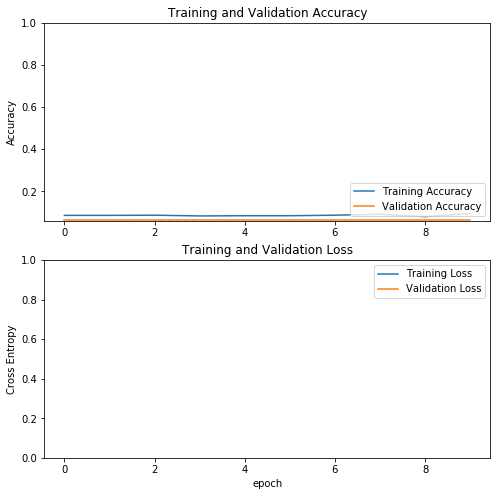

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

### Save Model

In [19]:
def export(model, path):
       model.save(path, save_format='tf')

In [20]:
model.save('/data/saved_model_2/')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /data/saved_model_2/assets


### Reload Model

In [11]:
import tensorflow as tf
model = tf.keras.models.load_model('/data/saved_model_2/')